In [329]:
import json
import pandas as pd
import os
from pathlib import Path
import sys
import numpy as np

sys.path.append("../")

from config import DATA_DIR
from graph_types.graph import Graph

graph = Graph.load("prime")

In [330]:
logs_dir = DATA_DIR / f"experiments/{graph.name}/subgraph_explorer"
json_files = sorted([f for f in logs_dir.glob("*.json")], key=lambda x: x.stat().st_ctime)

data = []

for json_file in json_files:
    with open(json_file, "r") as f:
        log_data = json.load(f)

    # Extract key information from each log entry
    record = {
        "file_id": int(json_file.stem),
        "question": log_data.get("question", ""),
        "all_nodes": log_data.get("all_nodes", []),
        "conversations_as_string": log_data.get("conversations_as_string", ""),
        "starting_nodes_indices": log_data.get("starting_nodes_indices", []),
        "agent_answer_indices": log_data.get("agent_answer_indices", []),
        "answer_indices": log_data.get("answer_indices", []),
    }

    data.append(record)

df = pd.DataFrame(data).reset_index(drop=True)# .sort_values(by="file_id").reset_index(drop=True)

df["recall@all"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"])))
    / len(set(row["answer_indices"])),
    axis=1,
)
df["hit@1"] = df.apply(
    lambda row: (
        row["agent_answer_indices"][0] in row["answer_indices"]
        if row["agent_answer_indices"]
        else False
    ),
    axis=1,
)
df["hit@5"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:5])))
    > 0,
    axis=1,
)
df["hit@10"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:10])))
    > 0,
    axis=1,
)
df["recall@20"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:20])))
    / len(set(row["answer_indices"])),
    axis=1,
)

[
    ("n", len(df)),
    ("Hit@1", float(round(df["hit@1"].mean(), 3))),
    ("Hit@5", float(round(df["hit@5"].mean(), 3))),
    ("Recall@20", float(round(df["recall@20"].mean(), 3))),
    ("Recall@all", float(round(df["recall@all"].mean(), 3))),
]

[('n', 100),
 ('Hit@1', 0.38),
 ('Hit@5', 0.65),
 ('Recall@20', 0.579),
 ('Recall@all', 0.584)]

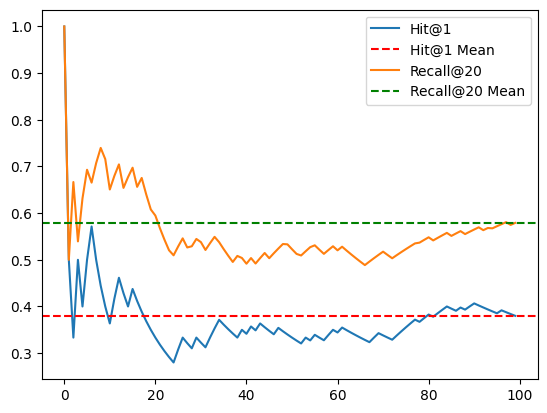

In [331]:
import matplotlib.pyplot as plt
plt.plot([df['hit@1'].iloc[:i].mean() for i in range(1, len(df) + 1)], label='Hit@1')
plt.axhline(y=df['hit@1'].mean(), color='r', linestyle='--', label='Hit@1 Mean')
plt.plot([df['recall@20'].iloc[:i].mean() for i in range(1, len(df) + 1)], label='Recall@20')
plt.axhline(y=df['recall@20'].mean(), color='g', linestyle='--', label='Recall@20 Mean')
plt.legend()


### When it went wrong, what happened?

In [332]:
df_wrong = df[df['recall@all'] == 0]

df_wrong['starting_node_names'] = df_wrong['starting_nodes_indices'].apply(
    lambda x: [graph.get_node_by_index(idx).name for idx in x]
)
df_wrong['answer_node_names'] = df_wrong['answer_indices'].apply(
    lambda x: [graph.get_node_by_index(idx).name for idx in x]
)   
df_wrong['agent_answer_node_names'] = df_wrong['agent_answer_indices'].apply(
    lambda x: [graph.get_node_by_index(idx).name for idx in x]
)   

/var/folders/rv/0brfn3g10137qh8fcq6ch2c00000gn/T/ipykernel_76927/1443130099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrong['starting_node_names'] = df_wrong['starting_nodes_indices'].apply(
/var/folders/rv/0brfn3g10137qh8fcq6ch2c00000gn/T/ipykernel_76927/1443130099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrong['answer_node_names'] = df_wrong['answer_indices'].apply(
/var/folders/rv/0brfn3g10137qh8fcq6ch2c00000gn/T/ipykernel_76927/1443130099.py:9: SettingWithCopyWarning: 
A value

In [333]:
for _, row in df_wrong.iterrows():
    print("Question:", row["question"], 'index', row["file_id"])
    print("Starting node names:", row["starting_node_names"])
    print("Starting nodes indices:", row["starting_nodes_indices"])
    print("Answer node names:", row["answer_node_names"])
    print("Answer indices:", row["answer_indices"])
    print("Agent answer node names:", row["agent_answer_node_names"])
    print()

Question: Could the symptoms of persistent fatigue, weakness, pallor, and intermittent dizziness I'm experiencing be related to my family's history of genetic lipodystrophy, and what potential diseases should I consider? index 148
Starting node names: ['Fatigue', 'Chronic fatigue', 'Muscle weakness', 'Pallor', 'Anemic pallor', 'genetic lipodystrophy', 'lipodystrophy', 'Family history']
Starting nodes indices: [25620, 89330, 22323, 22566, 84780, 38009, 31864, 26373]
Answer node names: ['lipoatrophy with diabetes, leukomelanodermic papules, liver steatosis, and hypertrophic cardiomyopathy']
Answer indices: [97982]
Agent answer node names: ['Fatigue', 'genetic lipodystrophy', 'lipodystrophy (disease)', 'constitutional megaloblastic anemia with severe neurologic disease', 'Diamond-Blackfan anemia', 'congenital generalized lipodystrophy', 'lipodystrophy', 'Fanconi anemia complementation group', 'Sheehan syndrome', 'POEMS syndrome', 'PMM2-CDG', 'familial glucocorticoid deficiency', 'ataxia t

In [334]:
graph.get_node_by_index(128417)

PrimeNode(name=Adrenaline,noradrenaline inhibits insulin secretion, index=128417, type=pathway)

In [335]:
graph.get_khop_subgraph(graph.get_node_by_index(37182), 2).nodes_df

,type,name,source,details,index
28131,disease,endocardial fibroelastosis,MONDO,"{""mondo_id"": 9169, ""mondo_name"": ""endocardial ...",28131
33670,disease,endocarditis,MONDO_grouped,"{""mondo_id"": 5025, ""mondo_name"": ""endocarditis...",33670
35669,disease,heart disease,MONDO,"{""mondo_id"": 5267, ""mondo_name"": ""heart diseas...",35669
35780,disease,cardiovascular neoplasm,MONDO,"{""mondo_id"": 24757, ""mondo_name"": ""cardiovascu...",35780
35785,disease,neoplasm of thorax,MONDO,"{""mondo_id"": 21350, ""mondo_name"": ""neoplasm of...",35785
36149,disease,heart cancer,MONDO,"{""mondo_id"": 1340, ""mondo_name"": ""heart cancer...",36149
36160,disease,heart neoplasm,MONDO,"{""mondo_id"": 21209, ""mondo_name"": ""heart neopl...",36160
36461,disease,cardiac germ cell tumor,MONDO,"{""mondo_id"": 20589, ""mondo_name"": ""cardiac ger...",36461
36972,disease,neoplasm of epicardium,MONDO,"{""mondo_id"": 21379, ""mondo_name"": ""neoplasm of...",36972
37182,disease,neoplasm of endocardium,MONDO,"{""mondo_id"": 21378, ""mondo_name"": ""neoplasm of...",37182


In [336]:
graph.get_node_by_index(96612)

PrimeNode(name=ovarian stromal hyperthecosis, index=96612, type=disease)